In [140]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [141]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)

nc = 2
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float

cf_amount = 1
cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    cfs.append(CounterfactualData([], index, target, label))

## Baseline

In [142]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 462 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (767) CFs (0)
Re-training surrogate model with data size: 767
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (6) Unique overall (6)
Generated random instances: (3725)
Predicted top: 20 Counterfactuals: 1
Found new best [ 1.78834537  1.79192348  0.01157307 -0.02499711 -1.87949933 -0.98758024
  1.58393292  1.30130806  0.13029487 -0.81691418 -0.62681893 -0.55456043
  0.08775111 -0.43600962  1.55205493 -0.48557608  0.55207597 -0.88017188
 -0.22501229 -0.71977594 -0.17999402  1.02636807 -0.20436697  0.47211629
  1.43455497  1.85005435  0.35042167 -0.89800721 -1.1580106   1.26263832], with fitness score 0.4148 (X 0.82957 Y 1.0 F 0.5), oversampling
Known alternatives: 787
Best instance score 0.4148 (X 0.82957 Y 

## Baycon

In [143]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 462 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (767) CFs (41)
Re-training surrogate model with data size: 767
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (40) Unique overall (40)
Generated random instances: (3732)
Predicted top: 20 Counterfactuals: 20
Found new best [ 0.81573649  1.79192348  1.11693983  1.7351068  -1.87949933  0.63692132
 -0.7770237   0.21688468 -0.38195669 -1.20037181 -0.54820219 -0.55456043
 -0.56386918  0.75829332 -0.56168241  0.76559213 -0.40397576 -0.88017188
 -0.77518075  0.92539796 -1.03230227  1.02636807  1.05103977  1.62289974
 -0.90076707  0.43899595 -0.59963519 -0.89800721 -0.89909082 -0.12626383], with fitness score 0.1917 (X 0.85572 Y 0.48 F 0.46667), oversampling
Known alternatives: 787
Best instance score 0.1917 (X 0.85572 Y 0.48 F 0.46667), found on ep

## CFDE

In [144]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([ 0.98649786,  1.79192348,  1.01866689,  0.97479724, -1.87949933,
        -0.98758024, -0.67846205, -0.81377811,  0.60339021, -1.20037181,
         0.86311672,  0.04416341,  0.46000235,  0.8137762 ,  0.01228944,
         0.69281919,  0.63976499, -0.88017188,  0.13798752,  0.40384985,
         1.05221312,  0.51705679,  0.69986791,  1.01391704, -1.34438516,
         0.78200271,  1.05144274, -0.89800721,  0.21783989, -1.06984764]), array([ 0.98649786,  1.79192348,  1.01866689,  0.97479724, -1.87949933,
        -0.98758024, -0.67846205, -0.81377811,  0.60339021, -1.20037181,
         0.51833737,  0.04416341,  0.86446528,  0.8137762 ,  0.01228944,
         0.45692275,  0.63976499, -0.88017188,  0.13798752,  0.40384985,
         0.90884862,  0.51705679,  1.07769473,  1.01391704, -1.34438516,
         0.95285513,  0.77656937, -0.89800721,  0.19897347, -1.06984764]), array([ 0.98649786,  1.79192348,  0.64017483,  0.97479724, -1.87949933,
        -0.98758024, -0.67

## CFAE

In [145]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([ 0.07745302,  1.79192348,  0.01157307, -0.02499711,  0.48596939,
         0.74893462,  1.07665434,  0.83734047, -0.38195669, -0.04471143,
         1.76889378, -0.55456043,  1.27198719,  1.11105252, -0.56168241,
        -0.48557608, -0.40397576,  0.52486931, -0.77518075,  0.44222774,
        -0.17999402,  1.02636807, -0.20436697, -0.2566256 ,  0.08175973,
        -0.68871694,  0.59018455, -0.89800721, -0.89909082, -1.06984764]), array([ 0.07745302,  1.79192348,  0.01157307,  1.69412119, -0.39035914,
         0.51507915, -0.67846205,  0.97420129, -0.38195669, -1.20037181,
         1.29642144, -0.55456043,  0.90049475,  1.0408246 , -0.56168241,
        -0.48557608, -0.40397576, -0.88017188,  0.73108651,  0.23391043,
        -0.17999402,  1.02636807, -0.20436697,  1.5211716 , -1.34438516,
         0.63340764, -0.59963519, -0.89800721,  1.27548537, -0.01947825]), array([ 0.07745302,  1.79192348,  0.01157307,  1.53707722,  0.75094357,
        -0.98758024,  1.51

## NeighborSearch

In [146]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

[CounterfactualData(cf=array([[ 0.70228425,  2.0455738 ,  0.67267578,  0.57795264, -0.84048388,
         -0.03867967,  0.04658753,  0.10577736, -0.80911707, -0.89558693,
          0.18489241, -0.2573709 ,  0.27669279, -0.43600962, -0.37934168,
          0.66127727,  0.5108265 ,  0.61215704, -0.89141612,  0.03672674,
          0.56136143,  1.37485378,  0.57900058,  0.42790561, -0.80958728,
          0.35073535,  0.3267666 ,  0.41406869, -1.10454895, -0.31840916],
        [ 0.7534068 , -0.11394449,  0.71386598,  0.65815634, -0.54870557,
         -0.23729117, -0.05749318,  0.43439269,  0.29711878, -1.0571938 ,
          0.69956576,  0.31596177,  0.62519434,  0.59411043, -0.30600538,
         -0.04348982, -0.18679726,  0.68839558,  0.04452071, -0.11419554,
          0.78293974,  0.10141534,  0.69814393,  0.66698174, -0.6824632 ,
         -0.26950087, -0.59963519,  0.49933764, -0.14682283, -0.6464708 ],
        [ 0.577318  ,  0.5236719 ,  0.58617636, -0.02499711,  0.31595455,
          0.45

# Dice Mod

In [147]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist


dice_cfs = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([
        # random_opt(instance, gainer.gain)[0][0] 
        adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
    for _ in range(1)])
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_cfs

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 102, score: 0.8397821213004374
(1, 30)
[array([0], dtype=int32)]


[CounterfactualData(cf=array([[ 1.07745142,  0.7919246 ,  1.01157163,  0.97500144, -0.87949992,
          0.01241903,  0.32153716,  0.18622116,  0.61804184, -0.20037282,
          0.3731801 ,  0.44543715,  0.4361298 ,  0.56398922,  0.43831507,
          0.51442269,  0.59602285,  0.11982724,  0.22481766,  0.28022277,
          0.8200048 ,  0.02637092,  0.7956319 ,  0.74337326, -0.3443859 ,
          0.31128217,  0.40036393,  0.10199209,  0.10090822, -0.0698485 ]]), instance=462, target=0, instance_label=np.int32(1))]

# threshold tree / imm

In [148]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
tt_dtc_prime_cfs = []
tt_imm_cfs = []
tt_imm_prime_cfs = []
print(centers)
for cf in cfs:
    tt_cf, tt_cf_prime = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

    tt_imm_cf, tt_imm_cf_prime = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_imm_prime_cfs.append(cf_data)



print(tt_dtc_cfs)
print(tt_dtc_prime_cfs)
print(tt_imm_cfs)
print(tt_imm_prime_cfs)

[[ 0.98649786  0.49202131  1.01866689  0.97479724  0.5871176   1.014073
   1.14492245  1.17028266  0.60339021  0.22927434  0.86311672  0.04416341
   0.86446528  0.8137762   0.01228944  0.69281919  0.63976499  0.77166695
   0.13798752  0.40384985  1.05221312  0.51705679  1.07769473  1.01391704
   0.59804381  0.95285513  1.05144274  1.15328841  0.5994129   0.61362004]
 [-0.48677585 -0.24278217 -0.50264928 -0.48100231 -0.28970632 -0.50038248
  -0.56494861 -0.57746231 -0.29773585 -0.11313275 -0.42589487 -0.02179192
  -0.4265603  -0.40154836 -0.00606408 -0.34186354 -0.31568456 -0.38077004
  -0.06808833 -0.19927499 -0.51920227 -0.25513563 -0.53177588 -0.50030552
  -0.29509774 -0.47017523 -0.51882214 -0.56907669 -0.29577329 -0.30278364]]
DTC accuracy: 0.9982425307557118

[0.         0.         0.         0.         0.         0.
 0.         1.11028829 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

## Testing

In [149]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}
dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}
tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing",
    "counterfactuals": tt_dtc_prime_cfs
}
tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}
tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing",
    "counterfactuals": tt_imm_prime_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs, dice_mod, tt_dtc, tt_dtc_prime, tt_imm, tt_imm_prime]

with open('testdata/data50Breast.pickle', 'wb') as handle:
    pickle.dump(methods, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('testdata/data50Breast.pickle', 'rb') as handle:
    b = pickle.load(handle)

methods = b
results, names = run(methods, centers, X, y)

In [150]:
max_name_length = max(len(m['name']) for m in methods)
mean_results = []

for i, n in enumerate(names):
    print(f"========== Mean {n} ==========")
    row = {}
    for m in methods:
        res = results[m['name']]
        res = [row[i] for row in res]
        r = []
        for current in range(cf_amount):
            r.extend([res[current]])
        try:
            r = np.mean(r[0])
        except:
            pass
        print(f"{m['name']:<{max_name_length}} {r:.4f}")
        row[m['name']] = r
    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=names)
mean_results_df


========== Mean Similarity ==========
Baseline                          5.0972
Baycon                            2.4701
CF-DE                             4.9129
CF-AE                             5.8144
NeighborSearch                    5.3875
dice_mod                          5.4772
ThresholdTree_DTC                 1.3847
ThresholdTree_DTC_Post_Proccesing 1.8498
ThresholdTree_IMM                 1.1103
ThresholdTree_IMM_Post_Proccesing 1.7219
========== Mean Minimality ==========
Baseline                          0.5778
Baycon                            0.7708
CF-DE                             0.3333
CF-AE                             0.5450
NeighborSearch                    0.1444
dice_mod                          0.0000
ThresholdTree_DTC                 0.0000
ThresholdTree_DTC_Post_Proccesing 0.0000
ThresholdTree_IMM                 0.9667
ThresholdTree_IMM_Post_Proccesing 0.9667
========== Mean Plausibility ==========
Baseline                          -1.4254
Baycon                

,Baseline,Baycon,CF-DE,CF-AE,NeighborSearch,dice_mod,ThresholdTree_DTC,ThresholdTree_DTC_Post_Proccesing,ThresholdTree_IMM,ThresholdTree_IMM_Post_Proccesing
Similarity,5.097159,2.470138e+00,4.912882e+00,5.814377,5.387549,5.477219,1.384699,1.849795,1.110288,1.721929
Minimality,0.577778,7.707602e-01,3.333333e-01,0.545000,0.144444,0.000000,0.000000,0.000000,0.966667,0.966667
Plausibility,-1.425443,-1.541277e+00,-1.316303e+00,-1.261071,-1.070330,-1.006654,-1.579920,-1.582370,-1.584157,-1.586080
Validity,0.111111,1.169591e-02,1.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Diversity,0.122203,5.031108e-52,8.789032e-07,0.505007,0.551557,1.080054,0.201006,0.477220,1.093029,1.077907


In [151]:
def plot(f1, f2, methods, results, names, plt_index):
    for idx, m in enumerate(methods):
        res = results[m['name']]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m['name']}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

Diversity


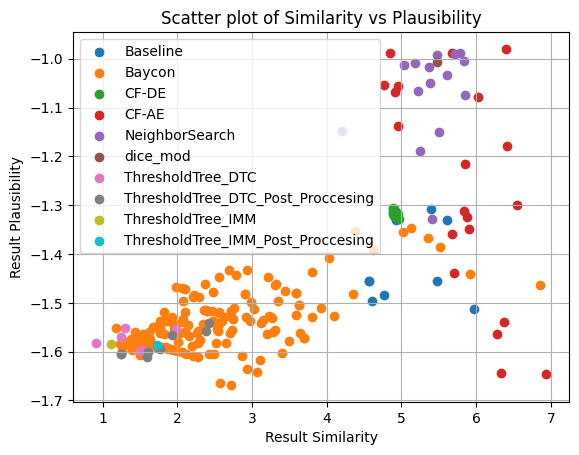

In [152]:
print(n)
for i in range(cf_amount):
    plot(0,2, methods, results, names, plt_index=i)

<Axes: >

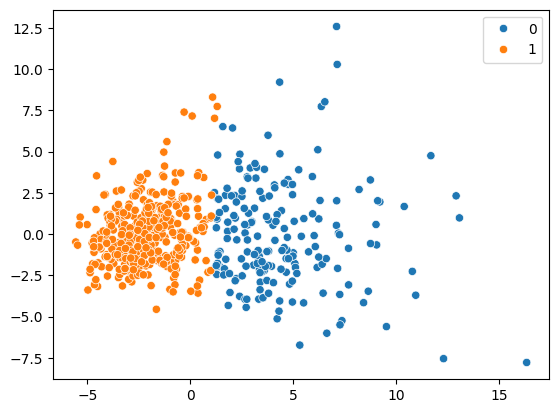

In [153]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

IndexError: list index out of range

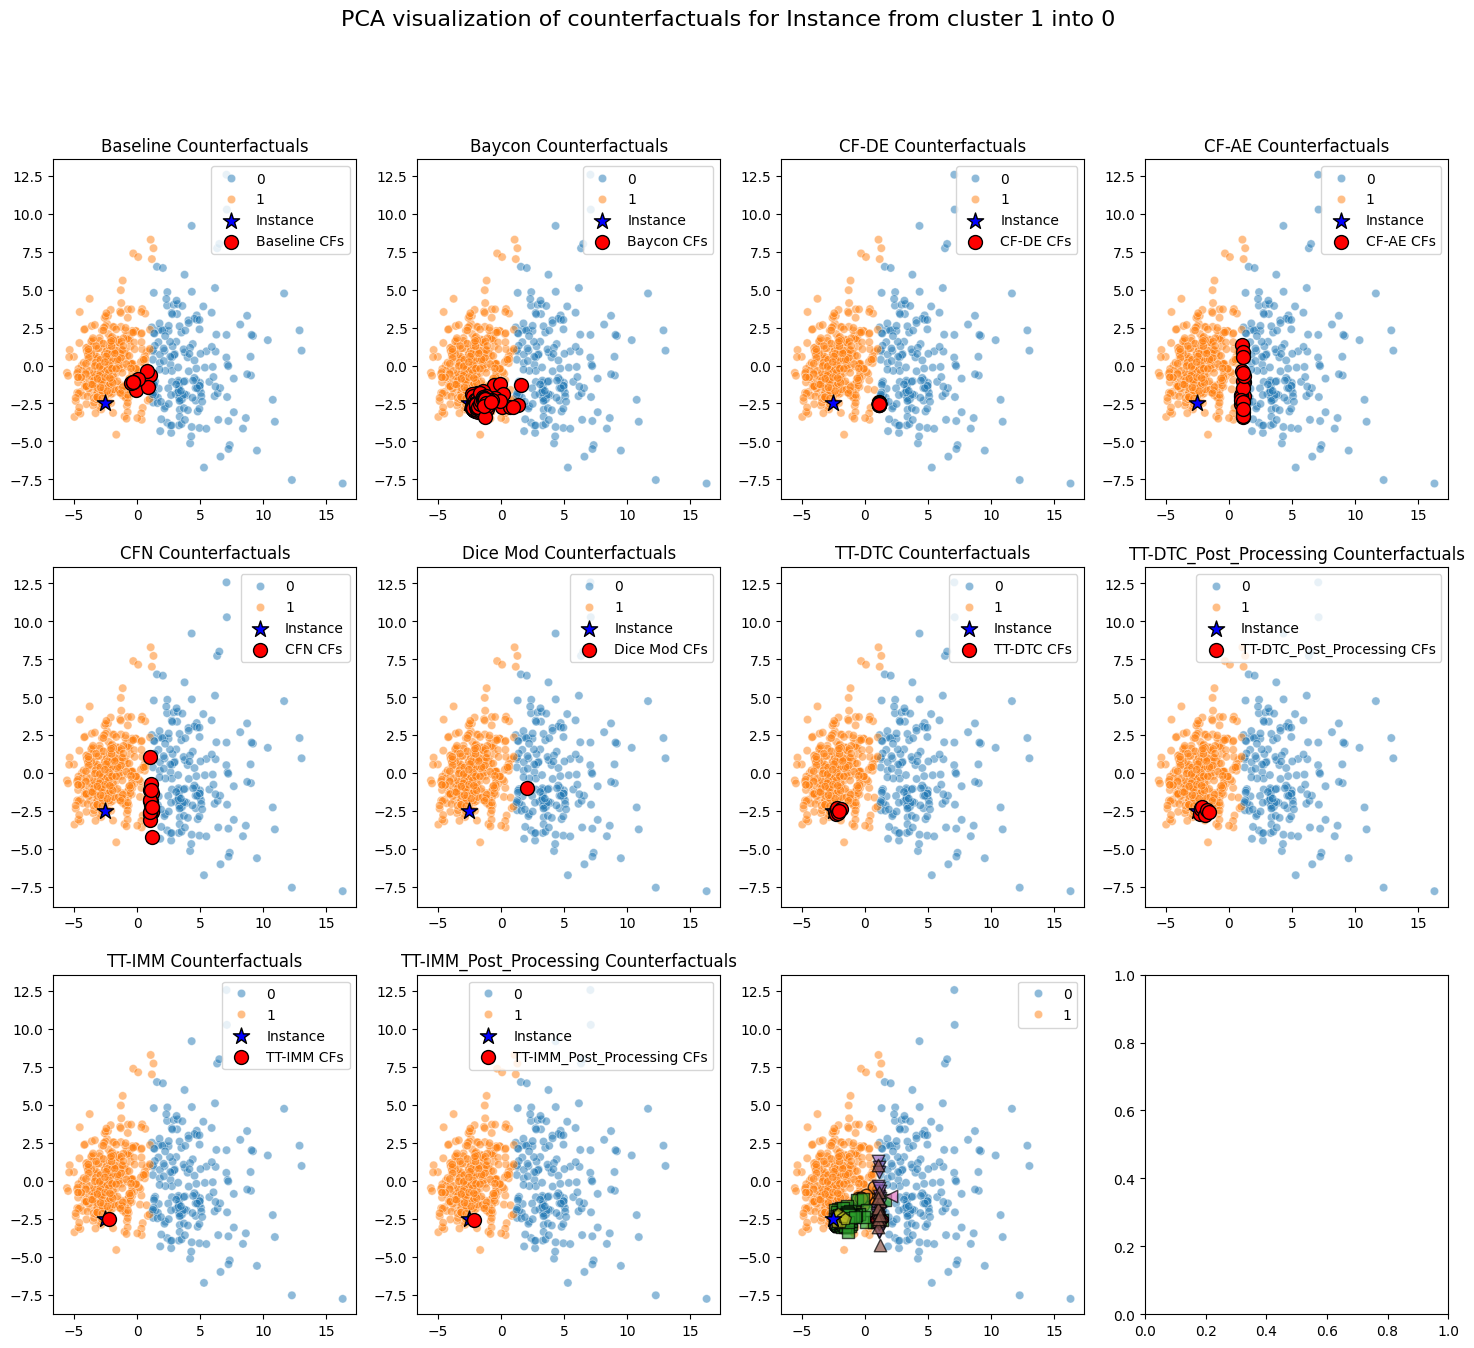

In [ ]:
cf_n = 0

fig, axs = plt.subplots(3, 4, figsize=(18, 15))
axs = axs.flatten()

# Transform data with PCA
baseline_embed = pca.transform(baseline_cfs[cf_n].cf)
baycon_embed = pca.transform(baycon_cfs[cf_n].cf)
cfde_embed = pca.transform(np.array(cfde_cfs[cf_n].cf))
cfae_embed = pca.transform(np.array(cfae_cfs[cf_n].cf))
cfn_embed = pca.transform(np.array(ns_cfs[cf_n].cf))
dice_embed = pca.transform(dice_cfs[cf_n].cf)
tt_dtc_embed = pca.transform(tt_dtc_cfs[cf_n].cf)
tt_dtc_prime_embed = pca.transform(tt_dtc_prime_cfs[cf_n].cf)
tt_imm_embed = pca.transform(tt_imm_cfs[cf_n].cf)
tt_imm_prime_embed = pca.transform(tt_imm_prime_cfs[cf_n].cf)
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

# Plot each method's counterfactuals
methods = [
    ('Baseline', baseline_embed),
    ('Baycon', baycon_embed),
    ('CF-DE', cfde_embed),
    ('CF-AE', cfae_embed),
    ('CFN', cfn_embed),
    ('Dice Mod', dice_embed),
    ('TT-DTC', tt_dtc_embed),
    ('TT-DTC_Post_Processing', tt_dtc_prime_embed),
    ('TT-IMM', tt_imm_embed),
    ('TT-IMM_Post_Processing', tt_imm_prime_embed)
]

# Base scatterplot of the data
for i in range(len(methods)):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

for i, (name, embed) in enumerate(methods):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods)])
axs[len(methods)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*', '&']
for i, (name, embed) in enumerate(methods):
    axs[len(methods)].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods)].set_title("All Methods Comparison")
axs[len(methods)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


## Running time

In [155]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, model=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 395 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (772) CFs (0)
Re-training surrogate model with data size: 772
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (5) Unique overall (5)
Generated random instances: (3720)
Predicted top: 20 Counterfactuals: 1
Found new best [-1.22360473 -0.49092937 -0.09140243 -0.13022891  0.84041121 -0.9614272
  1.16553554  1.02245633  0.06514743 -0.06283955  1.64460656 -0.42466606
  1.31626659 -0.60872304 -0.55668221 -0.71248761 -0.68216318 -1.26715141
 -0.40589132 -0.88923254 -0.27939364 -0.0549147  -1.05103977 -0.05901454
 -1.12958929 -0.83439294 -0.38227819  1.39220769 -0.61112587  1.32577023], with fitness score 0.4160 (X 0.83191 Y 1.0 F 0.5), oversampling
Known alternatives: 792
Best instance score 0.4160 (X 0.83191 Y 1

KeyboardInterrupt: 